In [1]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

from models.lstm_model import LSTMModel

import copy

from utils import *

torch.manual_seed(1)

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [3]:
df = df1

df

,consumption,temperature
2017-05-01 00:00:00+00:00,3325.431995,2.200000
2017-05-01 01:00:00+00:00,3344.690998,3.200000
2017-05-01 02:00:00+00:00,3398.359002,4.000000
2017-05-01 03:00:00+00:00,3430.220001,3.600000
2017-05-01 04:00:00+00:00,3606.750000,3.400000
...,...,...
2023-01-21 19:00:00+00:00,5947.502808,-10.233333
2023-01-21 20:00:00+00:00,5868.196111,-11.266667
2023-01-21 21:00:00+00:00,5742.156776,-12.016667
2023-01-21 22:00:00+00:00,5653.673398,-12.083333


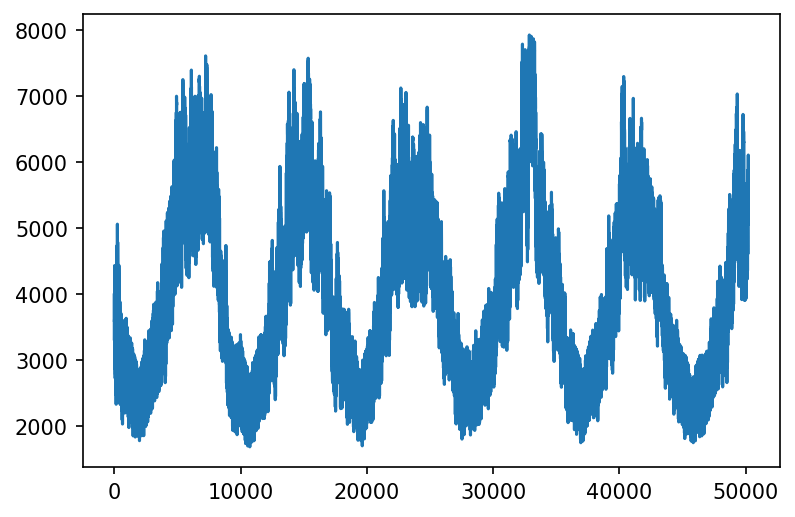

In [4]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(range(len(df['consumption'].values)), df['consumption'].values)
plt.show()

In [5]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1, shuffle=False)

In [6]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [7]:
df_train

,consumption,temperature
2017-05-01 00:00:00+00:00,-0.520736,-0.713648
2017-05-01 01:00:00+00:00,-0.506271,-0.593681
2017-05-01 02:00:00+00:00,-0.465960,-0.497708
2017-05-01 03:00:00+00:00,-0.442029,-0.545695
2017-05-01 04:00:00+00:00,-0.309436,-0.569688
...,...,...
2021-12-20 07:00:00+00:00,1.151071,-0.553693
2021-12-20 08:00:00+00:00,1.168536,-0.611676
2021-12-20 09:00:00+00:00,1.153706,-0.531699
2021-12-20 10:00:00+00:00,1.116430,-0.527700


In [8]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
    

In [9]:
tw = 100
pw = 1

train_dataset = SequenceDataset(generate_cnn_sequences(df_train, tw, pw))
val_dataset = SequenceDataset(generate_cnn_sequences(df_validation, tw, pw))
test_dataset = SequenceDataset(generate_cnn_sequences(df_test, tw, pw))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
# Init model
model = LSTMModel(device=device, n_features=2, n_hidden=64, n_outputs=1, sequence_len=100)
model.to(device)
model

LSTMModel(
  (lstm): LSTM(2, 64, batch_first=True)
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
def validation(val_loader, criterion, model):
    model.eval()
    val_losses = []
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y = y.squeeze()
        preds = model(x).squeeze()
        val_loss = criterion(preds, y)
        val_losses.append(val_loss)
    print(f"Validation Loss: {sum(val_losses) / len(val_losses)}")

In [13]:
# Training

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

for epoch in range(20):
    model.train()

    losses = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        y = y.squeeze()
        
        optimizer.zero_grad()

        preds = model(x).squeeze()

        loss = criterion(preds, y)
        losses.append(loss.item())

        loss.backward()

        optimizer.step()
    
    print(f"Epoch {epoch} train loss: {sum(losses) / len(losses)}")
    validation(val_loader, criterion, model)
    
torch.save(model.state_dict(), 'trained_models/lstm2.pth')

Epoch 0 train loss: 0.024868742027705875
Validation Loss: 0.008750900626182556
Epoch 1 train loss: 0.005829238348887482
Validation Loss: 0.0025189132429659367
Epoch 2 train loss: 0.002453304211094155
Validation Loss: 0.002324124798178673
Epoch 3 train loss: 0.0018839161759586056
Validation Loss: 0.0012399745173752308
Epoch 4 train loss: 0.001357832564637888
Validation Loss: 0.0011805319227278233
Epoch 5 train loss: 0.0012486754476857954
Validation Loss: 0.0015072703827172518
Epoch 6 train loss: 0.0010954473244632545
Validation Loss: 0.000940902391448617
Epoch 7 train loss: 0.0010736545144661895
Validation Loss: 0.0017426287522539496
Epoch 8 train loss: 0.0010055261944104928
Validation Loss: 0.000846226466819644
Epoch 9 train loss: 0.000988653178780502
Validation Loss: 0.0009628583211451769
Epoch 10 train loss: 0.0008956430887935011
Validation Loss: 0.0009091280517168343
Epoch 11 train loss: 0.0009001765276864759
Validation Loss: 0.0008642921457067132
Epoch 12 train loss: 0.000881291164

In [14]:
def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

In [15]:
predictions, actuals, test_loss = make_preds(model, test_loader, criterion)

In [16]:
print(predictions * train_std['consumption'] + train_mean['consumption'])
print(actuals * train_std['consumption'] + train_mean['consumption'])

[3107.562  6593.4673 6817.767  ... 3958.4788 3049.273  5052.975 ]
[3079.3843 6609.8457 6761.08   ... 3964.7637 3048.3628 5058.4775]


In [17]:
print(f"Final test loss: {test_loss}")

Final test loss: 0.0010593155166134238


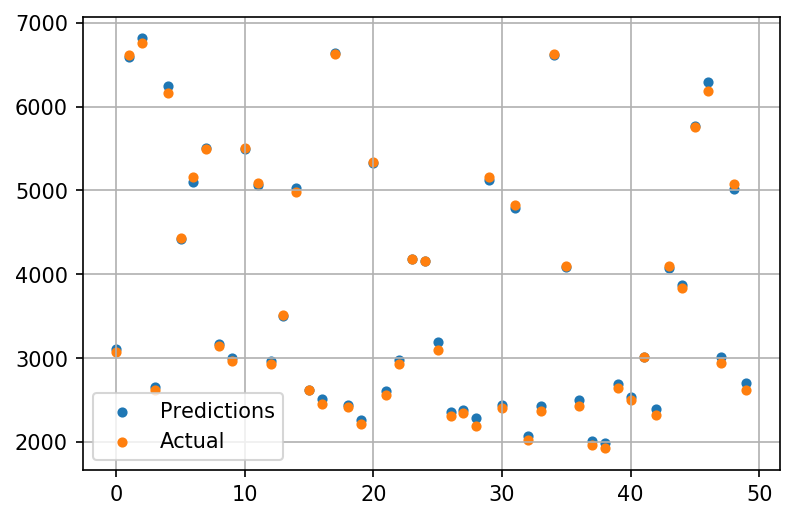

In [18]:
n = 50

pred = predictions[0:n] * train_std['consumption'] + train_mean['consumption']
act = actuals[0:n] * train_std['consumption'] + train_mean['consumption']

x = pred.shape[0]
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.scatter(range(x), pred, label="Predictions", s=15)
plt.scatter(range(x), act, label="Actual", s=15)
plt.legend()
plt.show()

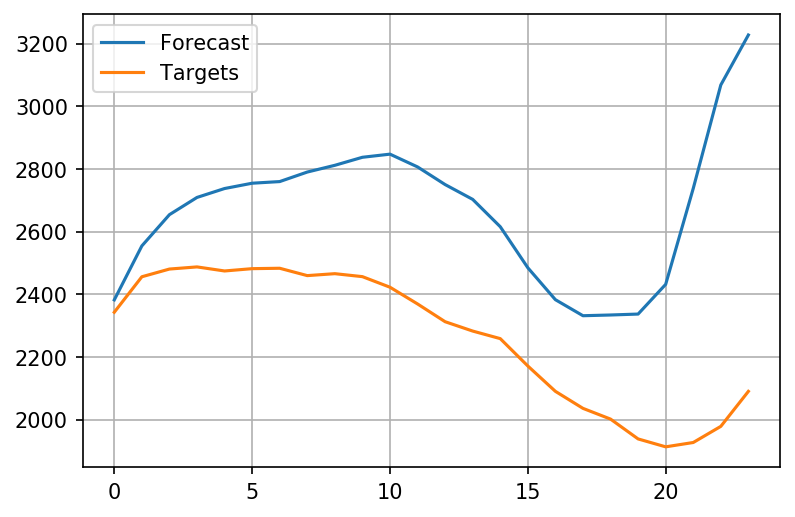

In [19]:
# Forecasting
start_point = 200
tw = 100
fw = 24

history = df_test.copy(deep=True)[start_point: start_point+tw+fw].values
targets = copy.deepcopy(history)[tw:tw+fw][:, 0]

pred_trgs = []

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = np.array(history[i:tw+i]).reshape(-1, 2)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    p = model(x)

    predictions.append(p.item())

    history[-fw+i, 0] = p.item()

predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()
